Code referred from [here](https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4)


TODO: Try following blog post for Alexnet using Torch [here](https://analyticsindiamag.com/implementing-alexnet-using-pytorch-as-a-transfer-learning-model-in-multi-class-classification/)

In [1]:
EPOCHS = 100
PATIENCE = EPOCHS

In [2]:
import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical

## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


#### AlexNet

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## Define AlexNet architecture
model = Sequential()
model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=train_ds[0].shape))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

## Preprocessing input
train_ds = train_ds / 255.0
test_ds = test_ds / 255.0

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=PATIENCE,  restore_best_weights=True)

history_alex = model.fit(train_ds, train_labels, epochs=EPOCHS, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/100
65/65 [==============================] - 15s 44ms/step - loss: 1.6133 - accuracy: 0.2477 - val_loss: 1.6108 - val_accuracy: 0.2490
Epoch 2/100
65/65 [==============================] - 2s 31ms/step - loss: 1.6026 - accuracy: 0.2491 - val_loss: 1.6135 - val_accuracy: 0.2490
Epoch 3/100
65/65 [==============================] - 2s 29ms/step - loss: 1.6016 - accuracy: 0.2482 - val_loss: 1.6053 - val_accuracy: 0.2490
Epoch 4/100
65/65 [==============================] - 2s 30ms/step - loss: 1.6019 - accuracy: 0.2467 - val_loss: 1.6042 - val_accuracy: 0.2490
Epoch 5/100
65/65 [==============================] - 2s 33ms/step - loss: 1.6016 - accuracy: 0.2501 - val_loss: 1.6089 - val_accuracy: 0.2490
Epoch 6/100
65/65 [==============================] - 2s 31ms/step - loss: 1.6040 - accuracy: 0.2414 - val_loss: 1.6071 - val_accuracy: 0.2490
Epoch 7/100
65/65 [==============================] - 2s 34ms/step - loss: 1.6019 - accuracy: 0.2487 - val_loss: 1.6079 - val_accuracy: 0.2490
Epoch

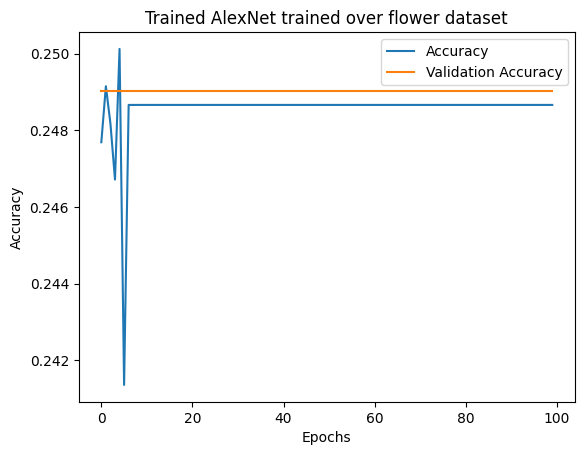

In [6]:
import matplotlib.pyplot as plt
plt.title("Trained AlexNet trained over flower dataset")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(history_alex.history["accuracy"], label = "Accuracy")
plt.plot(history_alex.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

#### VGG16

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

58889256/58889256 [==============================] - 4s 0us/step


In [8]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [9]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=PATIENCE,  restore_best_weights=True)

history = model.fit(train_ds, train_labels, epochs=EPOCHS, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/100
65/65 [==============================] - 13s 129ms/step - loss: 1.6536 - accuracy: 0.2253 - val_loss: 1.6209 - val_accuracy: 0.2490
Epoch 2/100
65/65 [==============================] - 6s 88ms/step - loss: 1.6061 - accuracy: 0.2482 - val_loss: 1.5981 - val_accuracy: 0.2490
Epoch 3/100
65/65 [==============================] - 6s 90ms/step - loss: 1.6029 - accuracy: 0.2467 - val_loss: 1.6273 - val_accuracy: 0.1498
Epoch 4/100
65/65 [==============================] - 6s 91ms/step - loss: 1.6009 - accuracy: 0.2438 - val_loss: 1.6024 - val_accuracy: 0.2490
Epoch 5/100
65/65 [==============================] - 6s 86ms/step - loss: 1.5978 - accuracy: 0.2584 - val_loss: 1.5901 - val_accuracy: 0.2879
Epoch 6/100
65/65 [==============================] - 6s 86ms/step - loss: 1.5880 - accuracy: 0.2725 - val_loss: 1.5882 - val_accuracy: 0.3016
Epoch 7/100
65/65 [==============================] - 6s 88ms/step - loss: 1.5882 - accuracy: 0.2409 - val_loss: 1.5833 - val_accuracy: 0.2918
Epoc

In [11]:
history.history.items()

dict_items([('loss', [1.6535953283309937, 1.60612952709198, 1.6029078960418701, 1.6009306907653809, 1.5978080034255981, 1.5879616737365723, 1.5881708860397339, 1.581439733505249, 1.5797529220581055, 1.565365195274353, 1.5642567873001099, 1.5705426931381226, 1.562384009361267, 1.5585204362869263, 1.553736686706543, 1.5501059293746948, 1.5515722036361694, 1.5406734943389893, 1.539786696434021, 1.5416839122772217, 1.5472415685653687, 1.542946696281433, 1.5330990552902222, 1.546221137046814, 1.5393505096435547, 1.5346779823303223, 1.5280760526657104, 1.5626380443572998, 1.530215859413147, 1.5233114957809448, 1.526774525642395, 1.5275460481643677, 1.5275335311889648, 1.5175861120224, 1.5274074077606201, 1.5216748714447021, 1.5109589099884033, 1.5090187788009644, 1.5032936334609985, 1.5056324005126953, 1.527739405632019, 1.5165023803710938, 1.5064336061477661, 1.4978795051574707, 1.5022460222244263, 1.5074461698532104, 1.4955270290374756, 1.4893335103988647, 1.489084243774414, 1.492467880249

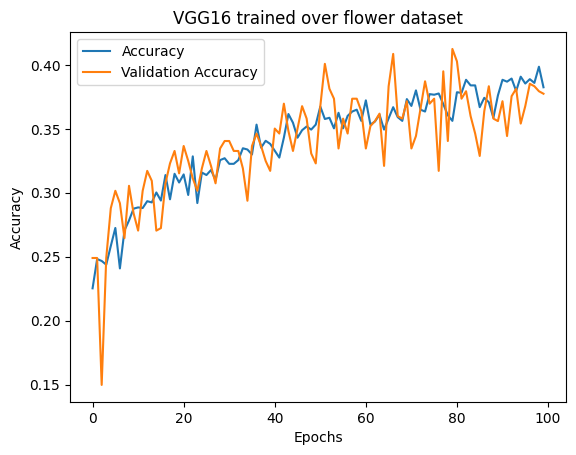

In [12]:
import matplotlib.pyplot as plt
plt.title("VGG16 trained over flower dataset")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(history.history["accuracy"], label = "Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

#### InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

## Loading InceptionV3 model
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=PATIENCE,  restore_best_weights=True)

history_inception = model.fit(train_ds, train_labels, epochs=EPOCHS, validation_split=0.2, batch_size=32, callbacks=[es])


Epoch 1/100
65/65 [==============================] - 14s 114ms/step - loss: 1.8174 - accuracy: 0.1995 - val_loss: 1.6088 - val_accuracy: 0.1809
Epoch 2/100
65/65 [==============================] - 3s 44ms/step - loss: 1.6074 - accuracy: 0.2136 - val_loss: 1.6075 - val_accuracy: 0.2490
Epoch 3/100
65/65 [==============================] - 3s 41ms/step - loss: 1.6054 - accuracy: 0.2487 - val_loss: 1.6065 - val_accuracy: 0.2490
Epoch 4/100
65/65 [==============================] - 3s 42ms/step - loss: 1.6037 - accuracy: 0.2487 - val_loss: 1.6060 - val_accuracy: 0.2490
Epoch 5/100
65/65 [==============================] - 3s 42ms/step - loss: 1.6025 - accuracy: 0.2487 - val_loss: 1.6058 - val_accuracy: 0.2490
Epoch 6/100
65/65 [==============================] - 3s 46ms/step - loss: 1.6015 - accuracy: 0.2487 - val_loss: 1.6055 - val_accuracy: 0.2490
Epoch 7/100
65/65 [==============================] - 3s 42ms/step - loss: 1.6009 - accuracy: 0.2487 - val_loss: 1.6056 - val_accuracy: 0.2490
Epoc

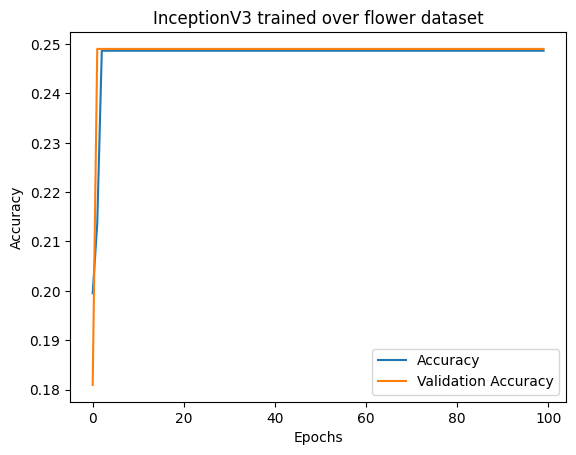

In [ ]:
import matplotlib.pyplot as plt
plt.title("InceptionV3 trained over flower dataset")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(history_inception.history["accuracy"], label = "Accuracy")
plt.plot(history_inception.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

#### ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

## Loading ResNet50 model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=PATIENCE,  restore_best_weights=True)

history_resnet = model.fit(train_ds, train_labels, epochs=EPOCHS, validation_split=0.2, batch_size=32, callbacks=[es])


In [ ]:
import matplotlib.pyplot as plt
plt.title("ResNet50 trained over flower dataset")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(history_resnet.history["accuracy"], label = "Accuracy")
plt.plot(history_resnet.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.title("Model comparison over tf_flower dataset")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(history.history["accuracy"], label = "VGG16 Accuracy")
plt.plot(history_resnet.history["accuracy"], label = "ResNet50 Accuracy")
plt.plot(history_inception.history["accuracy"], label = "InceptionV3 Accuracy")
plt.legend()
plt.show()

#### Plots

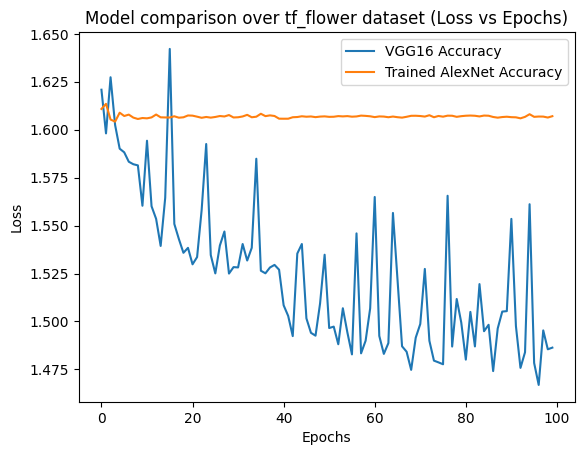

In [13]:
## TODO: Plots {acc vs epoch, learning curve}

import matplotlib.pyplot as plt
plt.title("Model comparison over tf_flower dataset (Loss vs Epochs)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history.history["val_loss"], label = "VGG16 Accuracy")
# plt.plot(history_resnet.history["val_loss"], label = "ResNet50 Accuracy")
# plt.plot(history_inception.history["val_loss"], label = "InceptionV3 Accuracy")
plt.plot(history_alex.history["val_loss"], label = "Trained AlexNet Accuracy")
plt.legend()
plt.show()

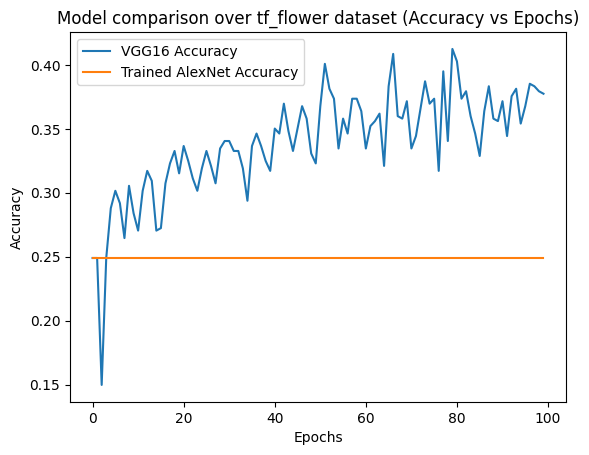

In [14]:
import matplotlib.pyplot as plt
plt.title("Model comparison over tf_flower dataset (Accuracy vs Epochs)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(history.history["val_accuracy"], label = "VGG16 Accuracy")
# plt.plot(history_resnet.history["val_accuracy"], label = "ResNet50 Accuracy")
# plt.plot(history_inception.history["val_accuracy"], label = "InceptionV3 Accuracy")
plt.plot(history_alex.history["val_accuracy"], label = "Trained AlexNet Accuracy")
plt.legend()
plt.show()